In [ ]:
!pip install keras

58889256/58889256 [==============================] - 3s 0us/step


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 977, 1738, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 977, 1738, 3), dtype=float32)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


iter=0, loss=249.4111328125
iter=1, loss=119.04364013671875
iter=2, loss=79.24779510498047
iter=3, loss=59.69729232788086
iter=4, loss=49.325687408447266
iter=5, loss=42.61451721191406
iter=6, loss=38.31465148925781
iter=7, loss=34.91674041748047
iter=8, loss=32.366451263427734
iter=9, loss=30.21170997619629
duration: 0:04:54.714597


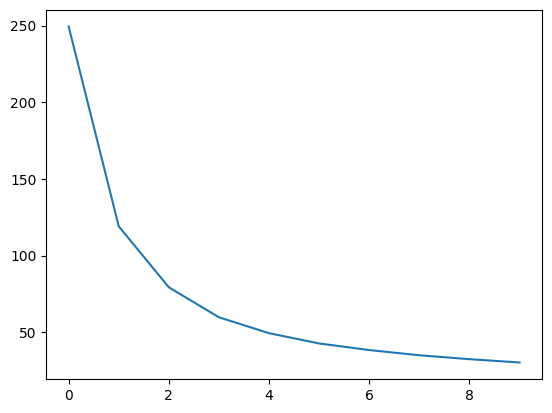

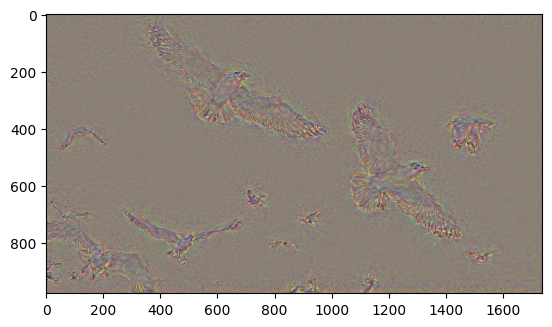

In [ ]:

from __future__ import print_function, division
from builtins import range, input


from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b


import tensorflow as tf
if tf.__version__.startswith('2'):
  tf.compat.v1.disable_eager_execution()


def VGG16_AvgPool(shape):

  vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

  # new_model = Sequential()
  # for layer in vgg.layers:
  #   if layer.__class__ == MaxPooling2D:
  #     # replace it with average pooling
  #     new_model.add(AveragePooling2D())
  #   else:
  #     new_model.add(layer)

  i = vgg.input
  x = i
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      # replace it with average pooling
      x = AveragePooling2D()(x)
    else:
      x = layer(x)

  return Model(i, x)

def VGG16_AvgPool_CutOff(shape, num_convs):
  # there are 13 convolutions in total
  # we can pick any of them as the "output"


  if num_convs < 1 or num_convs > 13:
    print("num_convs must be in the range [1, 13]")
    return None

  model = VGG16_AvgPool(shape)
  # new_model = Sequential()
  # n = 0
  # for layer in model.layers:
  #   if layer.__class__ == Conv2D:
  #     n += 1
  #   new_model.add(layer)
  #   if n >= num_convs:
  #     break

  n = 0
  output = None
  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n += 1
    if n >= num_convs:
      output = layer.output
      break

  return Model(model.input, output)


def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img


def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x


if __name__ == '__main__':

  # open an image
  # feel free to try your own
  # path = '../large_files/caltech101/101_ObjectCategories/elephant/image_0002.jpg'
  path = 'n.jpeg'
  img = image.load_img(path)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)


  batch_shape = x.shape
  shape = x.shape[1:]

  # see the image
  # plt.imshow(img)
  # plt.show()



  content_model = VGG16_AvgPool_CutOff(shape, 11)

  # make the target
  target = K.variable(content_model.predict(x))



  loss = K.mean(K.square(target - content_model.output))

  # gradients which are needed by the optimizer
  grads = K.gradients(loss, content_model.input)


  get_loss_and_grads = K.function(
    inputs=[content_model.input],
    outputs=[loss] + grads
  )


  def get_loss_and_grads_wrapper(x_vec):


    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)



  from datetime import datetime
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(10):
    x, l, _ = fmin_l_bfgs_b(
      func=get_loss_and_grads_wrapper,
      x0=x,
      # bounds=[[-127, 127]]*len(x.flatten()),
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    # print("min:", x.min(), "max:", x.max())
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)


  plt.imshow(scale_img(final_img[0]))
  plt.show()


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, 500, 400, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, 500, 400, 3), dtype=float32)


iter=0, loss=24596.84765625
iter=1, loss=1983.1937255859375
iter=2, loss=664.8782348632812
iter=3, loss=402.51983642578125
iter=4, loss=264.7182312011719
iter=5, loss=200.52406311035156
iter=6, loss=158.5481719970703
iter=7, loss=128.4690704345703
iter=8, loss=107.44329071044922
iter=9, loss=93.80419158935547
duration: 0:00:41.209486


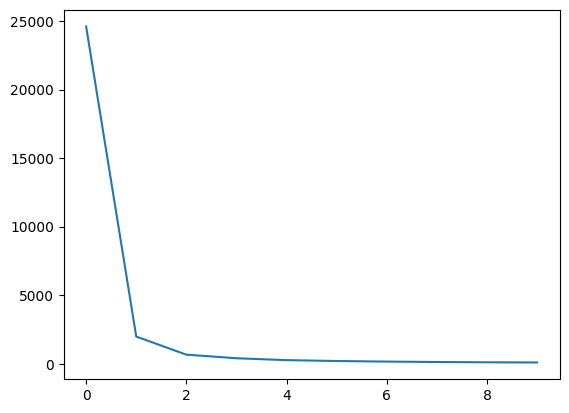

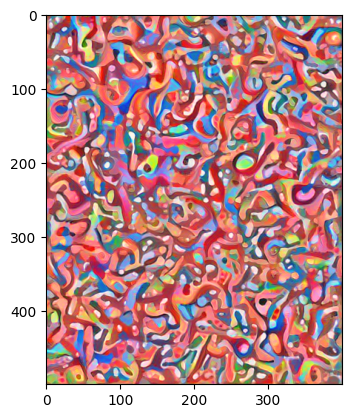

In [ ]:


from __future__ import print_function, division
from builtins import range, input


from keras.models import Model, Sequential
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16

from style_transfer1 import VGG16_AvgPool, unpreprocess, scale_img
# from skimage.transform import resize
from scipy.optimize import fmin_l_bfgs_b
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K



def gram_matrix(img):

  X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))

  # now, calculate the gram matrix
  # gram = XX^T / N
  G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
  return G


def style_loss(y, t):
  return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))


# let's generalize this and put it into a function
def minimize(fn, epochs, batch_shape):
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(
      func=fn,
      x0=x,
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)
  return final_img[0]


if __name__ == '__main__':
  # try these, or pick your own!
  path = '1.jpg'
  # path = 'styles/flowercarrier.jpg'
  # path = 'styles/monalisa.jpg'
  # path = 'styles/lesdemoisellesdavignon.jpg'


  # load the data
  img = image.load_img(path)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)


  # plt.imshow(x)
  # plt.show()

  x = np.expand_dims(x, axis=0)

  # preprocess into VGG expected format
  x = preprocess_input(x)


  batch_shape = x.shape
  shape = x.shape[1:]

  vgg = VGG16_AvgPool(shape)


  # index 0 correspond to the original vgg with maxpool
  symbolic_conv_outputs = [
    layer.get_output_at(1) for layer in vgg.layers \
    if layer.name.endswith('conv1')
  ]



  # make a big model that outputs multiple layers' outputs
  multi_output_model = Model(vgg.input, symbolic_conv_outputs)

  # calculate the targets that are output at each layer
  style_layers_outputs = [K.variable(y) for y in multi_output_model.predict(x)]

  # calculate the total style loss
  loss = 0
  for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs):
    # gram_matrix() expects a (H, W, C) as input
    loss += style_loss(symbolic[0], actual[0])

  grads = K.gradients(loss, multi_output_model.input)

  get_loss_and_grads = K.function(
    inputs=[multi_output_model.input],
    outputs=[loss] + grads
  )


  def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)


  final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
  plt.imshow(scale_img(final_img))
  plt.show()


In [ ]:


from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from skimage.transform import resize

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from style_transfer1 import VGG16_AvgPool, VGG16_AvgPool_CutOff, unpreprocess, scale_img
from style_transfer2 import gram_matrix, style_loss, minimize
from scipy.optimize import fmin_l_bfgs_b


# load the content image
def load_img_and_preprocess(path, shape=None):
  img = image.load_img(path, target_size=shape)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  return x



content_img = load_img_and_preprocess(
  # '../large_files/caltech101/101_ObjectCategories/elephant/image_0002.jpg',
  # 'batman.jpg',
  'n.jpeg',
  # (225, 300),
)

# resize the style image

h, w = content_img.shape[1:3]
style_img = load_img_and_preprocess(
  # 'styles/starrynight.jpg',
  # 'styles/flowercarrier.jpg',
  # 'styles/monalisa.jpg',
  '1.jpg',
  (h, w)
)



batch_shape = content_img.shape
shape = content_img.shape[1:]



vgg = VGG16_AvgPool(shape)


# create the content model

content_model = Model(vgg.input, vgg.layers[13].get_output_at(0))
content_target = K.variable(content_model.predict(content_img))


# create the style model
# we want multiple outputs
# we will take the same approach as in style_transfer2.py
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]

# make a big model that outputs multiple layers' outputs
style_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

style_weights = [0.2,0.4,0.3,0.5,0.2]



loss = K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  # gram_matrix() expects a (H, W, C) as input
  loss += w * style_loss(symbolic[0], actual[0])



grads = K.gradients(loss, vgg.input)


get_loss_and_grads = K.function(
  inputs=[vgg.input],
  outputs=[loss] + grads
)


def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)


final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))
plt.show()


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 977, 1738, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 977, 1738, 3), dtype=float32)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 977, 1738, 3), dtype=float32)
